In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable
from sklearn import decomposition

import numpy as np
import pickle
import pathlib

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda available


In [2]:
from core.SimpleConvNet import SimpleConvNet
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

from core.GraphConvNetCell import GraphConvNetCell


if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor


class GraphConvNet3(nn.Module):

    def __init__(self, net_parameters):

        super(GraphConvNet3, self).__init__()

        # parameters
        D = net_parameters['D']
        n_components = net_parameters['n_components']
        H = net_parameters['H']
        L = net_parameters['L']

        # vector of hidden dimensions
        net_layers = []
        for layer in range(L):
            net_layers.append(H)

        # CL cells
        # NOTE: Each graph convnet cell uses *TWO* convolutional operations
        net_layers_extended = [D] + net_layers  # include embedding dim
        L = len(net_layers)
        list_of_gnn_cells = []  # list of NN cells
        for layer in range(L // 2):
            Hin, Hout = net_layers_extended[2 * layer], net_layers_extended[2 * layer + 2]
            list_of_gnn_cells.append(GraphConvNetCell(Hin, Hout))

        # register the cells for pytorch
        self.gnn_cells = nn.ModuleList(list_of_gnn_cells)

        # fc
        Hfinal = net_layers_extended[-1]
        self.fc = nn.Linear(Hfinal, n_components)

        # init
        self.init_weights_Graph_OurConvNet(Hfinal, n_components, 1)

        # print('\nnb of hidden layers=', L)
        # print('dim of layers (w/ embed dim)=', net_layers_extended)
        # print('\n')

        # class variables
        self.L = L
        self.D = D
        self.net_layers_extended = net_layers_extended

    def init_weights_Graph_OurConvNet(self, Fin_fc, Fout_fc, gain):

        scale = gain * np.sqrt(2.0 / Fin_fc)
        self.fc.weight.data.uniform_(-scale, scale)
        self.fc.bias.data.fill_(0)

    def forward(self, G):
        # Data matrix
        x = G.data

        # Unroll the image vector
        x = x.view(x.shape[0], -1)
        
        # Peform initial PCA to reduce data dimensionality
        x = decomposition.TruncatedSVD(n_components=self.D).fit_transform(x)

        # Pass raw data matrix X directly as input
        x = Variable(torch.FloatTensor(x).type(dtypeFloat), requires_grad=False)

        # graph operators
        # Edge = start vertex to end vertex
        # E_start = E x V mapping matrix from edge index to corresponding start vertex
        # E_end = E x V mapping matrix from edge index to corresponding end vertex
        E_start = G.edge_to_starting_vertex
        E_end = G.edge_to_ending_vertex
        E_start = torch.from_numpy(E_start.toarray()).type(dtypeFloat)
        E_end = torch.from_numpy(E_end.toarray()).type(dtypeFloat)
        E_start = Variable(E_start, requires_grad=False)
        E_end = Variable(E_end, requires_grad=False)

        for layer in range(self.L // 2):
            gnn_layer = self.gnn_cells[layer]
            x = gnn_layer(x, E_start, E_end)  # V x Hfinal

        # FC
        x = self.fc(x)

        return x

    def loss(self, y, y_target):
        # L2 loss
        loss = nn.MSELoss()(y, y_target)

        return loss

    def pairwise_loss(self, y, y_target, W):
        distances_1 = y_target[W.row, :] - y_target[W.col, :]
        distances_2 = y[W.row, :] - y[W.col, :]
        loss = torch.mean(torch.pow(distances_1.norm(dim=1) - distances_2.norm(dim=1), 2))

        return loss

    def update(self, lr):

        update = torch.optim.Adam(self.parameters(), lr=lr)

        return update

    def update_learning_rate(self, optimizer, lr):

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    def nb_param(self):
        return self.nb_param


In [4]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [5]:
task_parameters = {}
task_parameters['conv_type'] = 'graph_net'
task_parameters['reduction_method'] = 'tsne'
task_parameters['n_components'] = 2

net_parameters = {}
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['D'] = 30 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H']

In [6]:
if task_parameters['conv_type'] == 'graph_net':
    net = GraphConvNet3(net_parameters)
elif task_parameters['conv_type'] == 'conv_net':
    net = SimpleConvNet(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

GraphConvNet3(
  (gnn_cells): ModuleList(
    (0): GraphConvNetCell(
      (Ui1): Linear(in_features=30, out_features=50, bias=False)
      (Uj1): Linear(in_features=30, out_features=50, bias=False)
      (Vi1): Linear(in_features=30, out_features=50, bias=False)
      (Vj1): Linear(in_features=30, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=30, out_features=50, bias=False)
    )
    (1): GraphConvNetCell(
      (Ui1): Linear(in_features=50, out_features=50, bias=False)
      (Uj1): Linear(in_features=50, out_features=50, bias=False)

In [7]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 200   
opt_parameters['max_train_size'] = 10000   
opt_parameters['batch_iters'] = 10
opt_parameters['save_flag'] = True

if 2==1: # fast debugging
    opt_parameters['max_train_size'] = 1000   
    opt_parameters['max_iters'] = 25 
    opt_parameters['batch_iters'] = 5
    opt_parameters['save_flag'] = False

opt_parameters['decay_rate'] = 1.25   

In [8]:
# Load Mnist dataset
parent_dir = os.path.abspath('..')
data_dir = parent_dir + '/data/mnist'
train_data = get_train_set(data_dir)
test_data = get_test_set(data_dir)

In [9]:
if opt_parameters['save_flag']: 
    checkpoint_interval = opt_parameters['max_iters']/5
    checkpoint_root = 'results/mnist_tsne5/'
    pathlib.Path(checkpoint_root).mkdir(exist_ok=True) 

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /home/leowyaoyang/data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [11]:
# # Initialise train_loader based on batch size
# batch_size = 200

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#                                            num_workers=2, pin_memory=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,
#                                           num_workers=2, pin_memory=False)

In [12]:
all_train_data = []
num_train_samples = 0
while num_train_samples <= opt_parameters['max_train_size']:
    # Draw a random training batch of variable size
    num_samples = np.random.randint(200, 500)
    inputs, labels = draw_random_subset(train_data, num_samples=num_samples)
    
    # Package into graph block
    G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
    
    all_train_data.append(G)
    num_train_samples += num_samples

In [13]:
dataset_sizes = [len(G.labels) for G in all_train_data]
print("Dataset sizes = {}".format(dataset_sizes))
print("Total number of samples = {}".format(num_train_samples))

Dataset sizes = [309, 462, 491, 474, 325, 287, 479, 481, 281, 209, 475, 391, 320, 230, 499, 456, 369, 466, 485, 495, 234, 265, 453, 443, 328, 342]
Total number of samples = 10049


In [14]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
    
for iteration in range(0, max_iters):
    
    for G in all_train_data:
        # Forward pass
        y_pred = net.forward(G)

        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

        # Compute L2 loss
        #loss = net.loss(y_pred, y_true)
        loss = net.pairwise_loss(y_pred, y_true, G.adj_matrix)
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        if 1==1:
            print('\niteration= %d, loss(%diter)= %.8f, lr= %.8f, time(%diter)= %.2f' % 
                  (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
    
    if opt_parameters['save_flag'] and not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + task_parameters['conv_type'] + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/home/leowyaoyang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 311.69467163, lr= 0.00075000, time(10iter)= 9.21

iteration= 10, loss(10iter)= 127.10308075, lr= 0.00075000, time(10iter)= 84.85

iteration= 20, loss(10iter)= 86.65925598, lr= 0.00075000, time(10iter)= 85.31

iteration= 30, loss(10iter)= 74.47219086, lr= 0.00075000, time(10iter)= 84.68

iteration= 40, loss(10iter)= 60.12028503, lr= 0.00075000, time(10iter)= 86.05

iteration= 50, loss(10iter)= 48.13037872, lr= 0.00075000, time(10iter)= 88.36

iteration= 60, loss(10iter)= 41.09452438, lr= 0.00075000, time(10iter)= 88.21

iteration= 70, loss(10iter)= 35.47157288, lr= 0.00075000, time(10iter)= 88.14

iteration= 80, loss(10iter)= 29.10501862, lr= 0.00075000, time(10iter)= 88.07

iteration= 90, loss(10iter)= 26.82000542, lr= 0.00075000, time(10iter)= 88.24

iteration= 100, loss(10iter)= 21.44205284, lr= 0.00075000, time(10iter)= 88.66

iteration= 110, loss(10iter)= 19.26797676, lr= 0.00075000, time(10iter)= 88.16

iteration= 120, loss(10iter)= 17.50731659, lr= 0.

## On test data

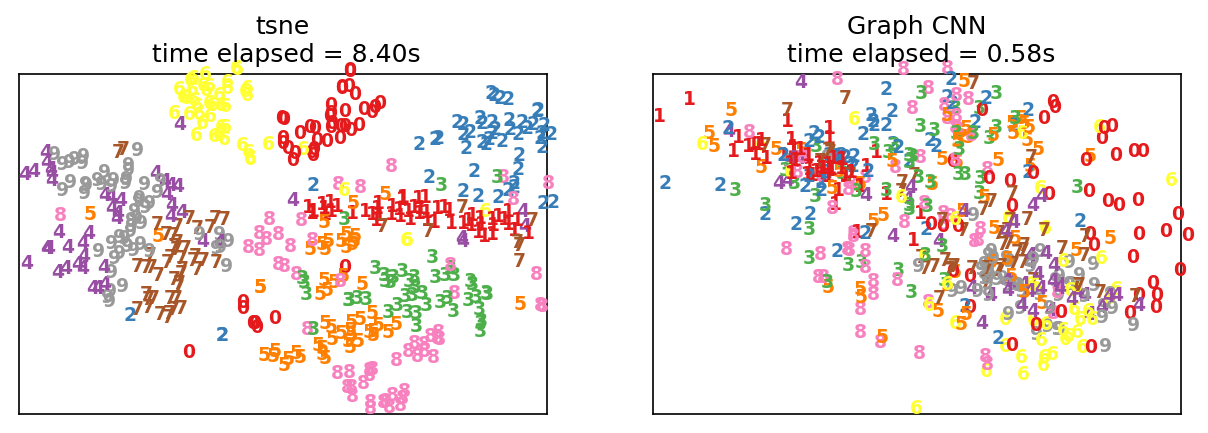

In [15]:
inputs, labels = draw_random_subset(test_data, num_samples=500)
G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
net_time_start = timer()
if torch.cuda.is_available():   
    y_pred = net.forward(G).cpu().detach().numpy()
else:    
    y_pred = net.forward(G).detach().numpy()
net_time_end = timer()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)

In [16]:
import json
if opt_parameters['save_flag']:
    metadata_filename = checkpoint_root + "experiment_metadata.txt"
    json.dump([opt_parameters, net_parameters], open(metadata_filename,'w'))